# 02 - Feature Engineering

This notebook transforms raw historical market data and financial statement information into structured numerical features suitable for machine learning applications. The process includes:

- **Technical indicators** derived from adjusted price and volume data to quantify trends, momentum, and volatility.

- **Fundamental ratios** calculated from quarterly and annual financial statements to represent financial health and valuation metrics.

These features form the foundation of the final dataset used in predictive modeling. The notebook ensures data is aligned, cleaned, and enriched to meet the requirements of downstream analysis.

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import talib
import warnings

In [ ]:
# Suppress all warnings
warnings.filterwarnings('ignore')

In [3]:
# Stock for testing
stock = "AAPL"
base_path = f"dataset\\Stocks\\{stock}\\"

## 1. Data Preparation

This section prepares the input data by performing three key tasks:

- **Load** historical price data and financial statements from CSV files.
- **Identify** the latest common start date across all datasets to ensure consistent alignment.
- **Trim** each dataframe so all begin from this unified start date and remove any duplicate index entries.

### 1.1 Load Raw Data

In [4]:
def load_dataframes(base_path, stock):
    """
    Load historical price data and financial statements for a given stock from CSV files.

    Parameters:
        base_path (str): Path to the directory containing stock data.
        stock (str): Stock ticker symbol.

    Returns:
        tuple: DataFrames in the following order:
            - history_raw
            - history_adj
            - balance_sheet_annual
            - balance_sheet_quarterly
            - income_statement_annual
            - income_statement_quarterly
            - cash_flow_annual
            - cash_flow_quarterly
    """
    filenames = [
        f"{stock}_history_raw.csv",
        f"{stock}_history_adj.csv",
        f"{stock}_annual_balance_sheet.csv",
        f"{stock}_quarterly_balance_sheet.csv",
        f"{stock}_annual_income_statement.csv",
        f"{stock}_quarterly_income_statement.csv",
        f"{stock}_annual_cashflow_statement.csv",
        f"{stock}_quarterly_cashflow_statement.csv",
    ]

    # Construct full file paths
    full_paths = [os.path.join(base_path, f) for f in filenames]

    # Verify that all required files exist
    for path in full_paths:
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Missing file: {path}")

    # Load CSVs into pandas DataFrames
    return tuple(pd.read_csv(path, index_col=0, parse_dates=True) for path in full_paths)

In [5]:
(
    history_raw, history_adj,
    balance_sheet_annual, balance_sheet_quarterly,
    income_statement_annual, income_statement_quarterly,
    cash_flow_annual, cash_flow_quarterly
) = load_dataframes(base_path, stock)

### 1.2 Determine Common Start Date 

In [ ]:
def determine_start_date(
    history_raw, history_adj,
    balance_sheet_annual, balance_sheet_quarterly,
    income_statement_annual, income_statement_quarterly,
    cash_flow_annual, cash_flow_quarterly
):
    """
    Determine the latest available starting date across all datasets to ensure temporal alignment.

    parameters:
        DataFrames in the following order:
            - history_raw
            - history_adj
            - balance_sheet_annual
            - balance_sheet_quarterly
            - income_statement_annual
            - income_statement_quarterly
            - cash_flow_annual
            - cash_flow_quarterly

    Returns:
        datetime: Latest common start date shared by all input DataFrames.
    """
    dates = [
        history_raw.index.min(),
        history_adj.index.min(),
        balance_sheet_annual.index.min(),
        balance_sheet_quarterly.index.min(),
        income_statement_annual.index.min(),
        income_statement_quarterly.index.min(),
        cash_flow_annual.index.min(),
        cash_flow_quarterly.index.min()
    ]
    
    # Convert to datetime and return the latest (most restrictive) start date
    start_date = pd.to_datetime(max(dates))
    return start_date

In [7]:
start_date = determine_start_date(history_raw, history_adj, balance_sheet_annual, balance_sheet_quarterly, income_statement_annual, income_statement_quarterly, cash_flow_annual, cash_flow_quarterly)
start_date

Timestamp('2005-09-30 00:00:00')

### 1.3 Remove Index Duplicates and Align Dataframes

In [8]:
def prepare_financial_data(
    start_date,
    history_raw, history_adj,
    balance_sheet_annual, balance_sheet_quarterly,
    income_statement_annual, income_statement_quarterly,
    cash_flow_annual, cash_flow_quarterly
):
    """
    Clean and align all financial DataFrames.

    This function performs two preprocessing steps:
    1. Removes duplicate index entries (keeps the first occurrence).
    2. Slices each DataFrame to include data starting from the given start_date.

    Parameters:
        start_date (datetime): The cutoff date from which all data should be retained.
        DataFrames in the following order:
            - history_raw
            - history_adj
            - balance_sheet_annual
            - balance_sheet_quarterly
            - income_statement_annual
            - income_statement_quarterly
            - cash_flow_annual
            - cash_flow_quarterly

    Returns:
        tuple: Cleaned and aligned DataFrames in the original order.
    """
    def clean_and_slice(df):
        if df.index.duplicated().any():
            df = df[~df.index.duplicated(keep='first')]
        return df[df.index >= start_date]

    history_raw = clean_and_slice(history_raw)
    history_adj = clean_and_slice(history_adj)
    balance_sheet_annual = clean_and_slice(balance_sheet_annual)
    balance_sheet_quarterly = clean_and_slice(balance_sheet_quarterly)
    income_statement_annual = clean_and_slice(income_statement_annual)
    income_statement_quarterly = clean_and_slice(income_statement_quarterly)
    cash_flow_annual = clean_and_slice(cash_flow_annual)
    cash_flow_quarterly = clean_and_slice(cash_flow_quarterly)

    return (
        history_raw,
        history_adj,
        balance_sheet_annual,
        balance_sheet_quarterly,
        income_statement_annual,
        income_statement_quarterly,
        cash_flow_annual,
        cash_flow_quarterly
    )

In [9]:
(
    history_raw,
    history_adj,
    balance_sheet_annual,
    balance_sheet_quarterly,
    income_statement_annual,
    income_statement_quarterly,
    cash_flow_annual,
    cash_flow_quarterly
) = prepare_financial_data(
    start_date,
    history_raw,
    history_adj,
    balance_sheet_annual,
    balance_sheet_quarterly,
    income_statement_annual,
    income_statement_quarterly,
    cash_flow_annual,
    cash_flow_quarterly
)

## 2. Technical Indicators

Technical indicators are mathematical calculations based on historical price and volume data. They are commonly used in financial analysis to identify trends, measure momentum, assess volatility, and detect overbought or oversold conditions in the market.

These indicators are derived from the adjusted price data of a stock and are used to capture behavioral patterns and trading signals that may not be visible through raw prices alone.

While technical indicators originated in the context of chart-based trading (technical analysis), they are increasingly used as quantitative features in machine learning models for stock prediction.

This section computes a set of widely used indicators grouped by their analytical focus:
- **Trend and momentum** (e.g., SMA, EMA, MACD, ROC)
- **Volatility** (e.g., Bollinger Bands, ATR)
- **Volume-based** (e.g., OBV)
- **Oscillators** (e.g., RSI, Stochastic Oscillator)

### 2.1 Trend and Momentum Indicators

These indicators help identify the direction and strength of price movements over time. They are often used to detect trend continuation or reversal.

#### Simple Moving Average (SMA)

The SMA is the average of closing prices over a specified period. It smooths out short-term fluctuations and highlights longer-term trends. Common periods include 10, 50, or 200 days.

In [10]:
def calculate_sma(history_adj, window=10):
    """
    Compute the Simple Moving Average (SMA) over a specified window.
    
    Parameters:
        history_adj (DataFrame): Must contain 'close_adj' column.
        window (int): Number of periods for the moving average.
    
    Returns:
        Series: SMA values.
    """
    return talib.SMA(history_adj['close_adj'], timeperiod=window)

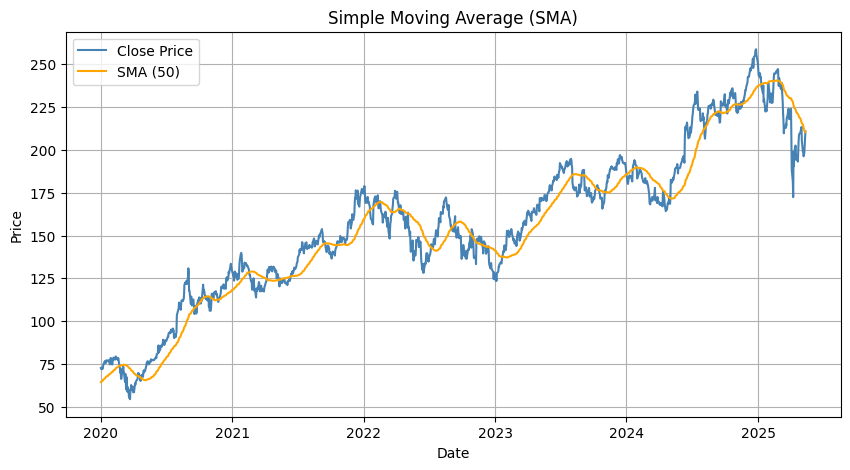

In [11]:
# Plot Simple Moving Average (SMA)
plot_data = history_adj.loc['2020-01-01':]
sma = calculate_sma(history_adj, window=50).loc['2020-01-01':]

plt.figure(figsize=(10, 5))
plt.plot(plot_data.index, plot_data['close_adj'], label='Close Price', color='steelblue')
plt.plot(sma.index, sma, label='SMA (50)', color='orange')
plt.title('Simple Moving Average (SMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


#### Exponential Moving Average (EMA)

The EMA gives more weight to recent prices compared to the SMA, making it more responsive to new information. Common values include 12 and 26 periods.

In [12]:
def calculate_ema(history_adj, span=12):
    """
    Compute the Exponential Moving Average (EMA).
    
    Parameters:
        history_adj (DataFrame): Must contain 'close_adj' column.
        span (int): Number of periods for EMA calculation.
    
    Returns:
        Series: EMA values.
    """
    return talib.EMA(history_adj['close_adj'], timeperiod=span)

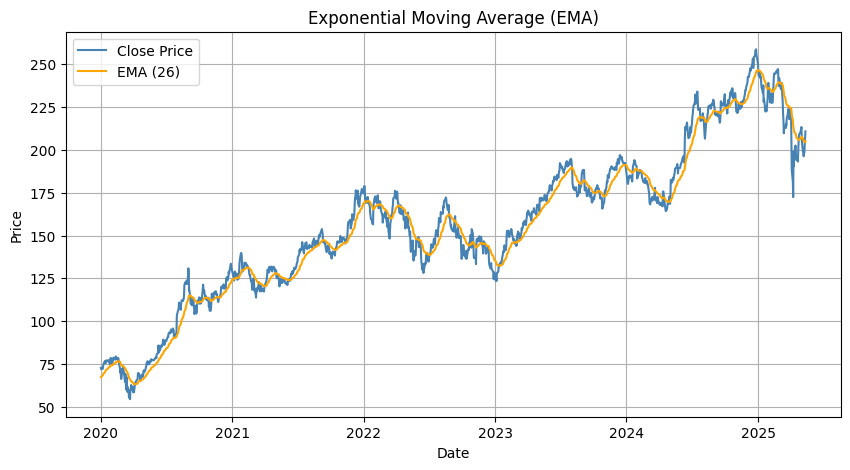

In [13]:
# Plot Exponential Moving Average (EMA)
ema = calculate_ema(history_adj, span=26).loc['2020-01-01':]

plt.figure(figsize=(10, 5))
plt.plot(plot_data.index, plot_data['close_adj'], label='Close Price', color='steelblue')
plt.plot(ema.index, ema, label='EMA (26)', color='orange')
plt.title('Exponential Moving Average (EMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Moving Average Convergence Divergence (MACD)

MACD is a momentum indicator that shows the relationship between two EMAs (typically 12 and 26 periods). A signal line (9-period EMA of the MACD) is used to generate buy/sell signals when it crosses the MACD line.

- **MACD line**: 12-day EMA − 26-day EMA  

- **Signal line**: 9-day EMA of the MACD line  

- **Use**: Detect trend changes and momentum shifts

In [14]:
def calculate_macd(history_adj):
    """
    Compute the MACD line and signal line.
    
    Parameters:
        history_adj (DataFrame): Must contain 'close_adj' column.
    
    Returns:
        Tuple of Series: (MACD line, Signal line)
    """
    macd, signal, _ = talib.MACD(
        history_adj['close_adj'],
        fastperiod=12,
        slowperiod=26,
        signalperiod=9
    )
    return macd, signal

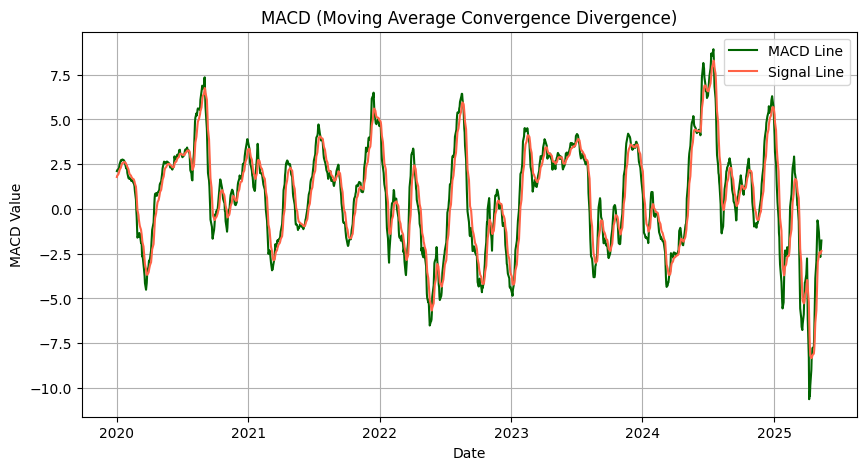

In [15]:
# Plot MACD and Signal Line
macd, signal = calculate_macd(history_adj)
macd = macd.loc['2020-01-01':]
signal = signal.loc['2020-01-01':]

plt.figure(figsize=(10, 5))
plt.plot(macd.index, macd, label='MACD Line', color='darkgreen')
plt.plot(signal.index, signal, label='Signal Line', color='tomato')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()

#### Rate of Change (ROC)

ROC measures the percentage change in price compared to a previous period. It captures momentum and is used to identify trend strength or potential reversals.

- **Formula**: \[(Current Price − Price N periods ago) / Price N periods ago\] × 100

- **Use**: Identify accelerating trends or overbought/oversold conditions

In [16]:
def calculate_roc(history_adj, window=12):
    """
    Compute the Rate of Change (ROC).
    
    Parameters:
        history_adj (DataFrame): Must contain 'close_adj' column.
        window (int): Number of periods to calculate the change.
    
    Returns:
        Series: ROC values.
    """
    return talib.ROC(history_adj['close_adj'], timeperiod=window)

### 2.2 Volatility Indicators

Volatility indicators measure the degree of variation in price movements. They help quantify market uncertainty and are often used to assess risk and identify breakout conditions.

#### Bollinger Bands

Bollinger Bands consist of three lines: a simple moving average (middle band), and two bands above and below it at a specified number of standard deviations. Prices moving outside the bands may signal overbought or oversold conditions.

- **Middle band**: SMA  

- **Upper/Lower bands**: SMA ± 2× standard deviation  

- **Use**: Detect volatility spikes and potential reversal zones

In [17]:
def calculate_bollinger_bands(history_adj, window=20):
    """
    Compute Bollinger Bands: upper, middle, and lower bands.
    
    Parameters:
        history_adj (DataFrame): Must contain 'close_adj' column.
        window (int): Rolling window period.
    
    Returns:
        Tuple of Series: (Upper band, Middle band, Lower band)
    """
    upper, middle, lower = talib.BBANDS(history_adj['close_adj'], timeperiod=window)
    return upper, middle, lower

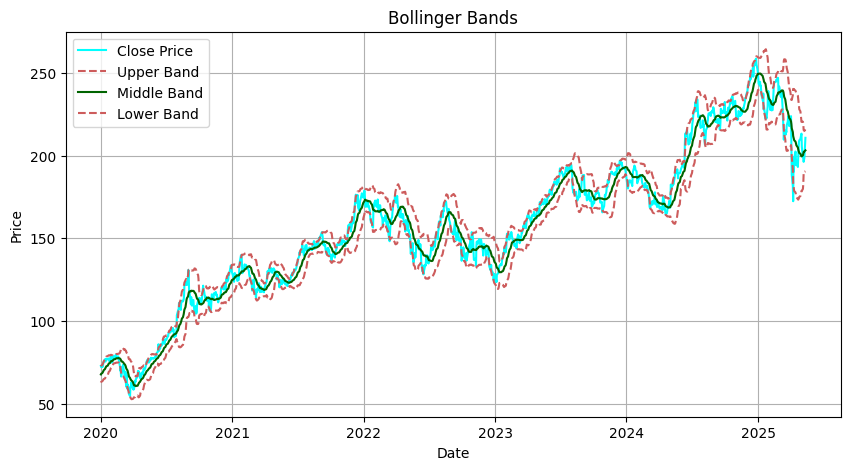

In [18]:
# Plot Bollinger Bands
upper, middle, lower = calculate_bollinger_bands(history_adj, window=20)
upper = upper.loc['2020-01-01':]
middle = middle.loc['2020-01-01':]
lower = lower.loc['2020-01-01':]

plt.figure(figsize=(10, 5))
plt.plot(plot_data.index, plot_data['close_adj'], label='Close Price', color='cyan')
plt.plot(upper.index, upper, label='Upper Band', color='indianred', linestyle='--')
plt.plot(middle.index, middle, label='Middle Band', color='darkgreen')
plt.plot(lower.index, lower, label='Lower Band', color='indianred', linestyle='--')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


#### Average True Range (ATR)

ATR measures market volatility by accounting for the full range of price movement over a given period. It considers gaps and limit moves between trading sessions.

- **Formula**: Moving average of the True Range over N periods  

- **Use**: Assess volatility, set stop-loss levels

In [19]:
def calculate_atr(history_adj, window=14):
    """
    Compute the Average True Range (ATR).
    
    Parameters:
        history_adj (DataFrame): Must contain 'high_adj', 'low_adj', and 'close_adj'.
        window (int): Number of periods for calculation.
    
    Returns:
        Series: ATR values.
    """
    return talib.ATR(history_adj['high_adj'], history_adj['low_adj'], history_adj['close_adj'], timeperiod=window)

### 2.3 Volume-Based Indicator

Volume-based indicators provide insight into the strength of price movements. High volume confirms trends, while divergences between price and volume can indicate weakening momentum.

#### On-Balance Volume (OBV)

OBV uses cumulative volume to measure buying and selling pressure. Volume is added on up days and subtracted on down days.

- **Use**: Confirm trends and anticipate reversals through divergence analysis

In [20]:
def calculate_obv(history_adj):
    """
    Compute On-Balance Volume (OBV).
    
    Parameters:
        history_adj (DataFrame): Must contain 'close_adj' and 'volume_adj'.
    
    Returns:
        Series: OBV values.
    """
    return talib.OBV(history_adj['close_adj'], history_adj['volume_adj'])

### 2.4 Oscillators

Oscillators are bounded indicators that fluctuate within a fixed range. They help identify overbought or oversold conditions and are commonly used in mean-reversion strategies.

#### Relative Strength Index (RSI)

RSI measures the magnitude of recent price changes to evaluate overbought or oversold conditions.

- **Range**: 0–100  
- **Typical Thresholds**: Above 70 = overbought, below 30 = oversold

In [21]:
def calculate_rsi(history_adj, window=14):
    """
    Compute the Relative Strength Index (RSI).
    
    Parameters:
        history_adj (DataFrame): Must contain 'close_adj'.
        window (int): Number of periods.
    
    Returns:
        Series: RSI values.
    """
    return talib.RSI(history_adj['close_adj'], timeperiod=window)

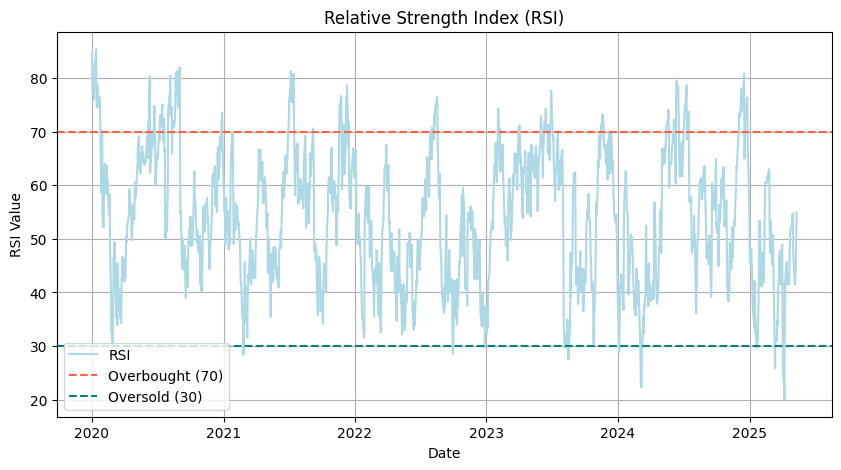

In [22]:
# Plot Relative Strength Index (RSI)
rsi = calculate_rsi(history_adj, window=14).loc['2020-01-01':]

plt.figure(figsize=(10, 5))
plt.plot(rsi.index, rsi, label='RSI', color='lightblue')
plt.axhline(70, color='tomato', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='teal', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()

#### Stochastic Oscillator

The Stochastic Oscillator compares a stock's closing price to its price range over a set period, usually 14 days. The indicator is composed of two lines:

- **%K** (the fast line): Shows the relative position of the current closing price within the price range of the given period.
- **%D** (the slow line): A moving average of the %K line, usually calculated over 3 periods.

The Stochastic Oscillator oscillates between **0 and 100** and is used to identify overbought and oversold conditions:

- **Above 80**: Overbought (potential for reversal downward)
- **Below 20**: Oversold (potential for reversal upward)

The Stochastic Oscillator is particularly useful in spotting **momentum shifts** and **potential reversal points** in the market.

In [23]:
def calculate_stochastic(history_adj, k_period=14, d_period=3):
    """
    Compute the Stochastic Oscillator (%K and %D).
    
    Parameters:
        history_adj (DataFrame): Must contain 'high_adj', 'low_adj', and 'close_adj'.
        k_period (int): Number of periods for %K.
        d_period (int): Smoothing factor for %D.
    
    Returns:
        Tuple of Series: (%K, %D)
    """
    slowk, slowd = talib.STOCH(
        history_adj['high_adj'],
        history_adj['low_adj'],
        history_adj['close_adj'],
        fastk_period=k_period,
        slowk_period=3,
        slowk_matype=0,
        slowd_period=d_period,
        slowd_matype=0
    )
    return slowk, slowd

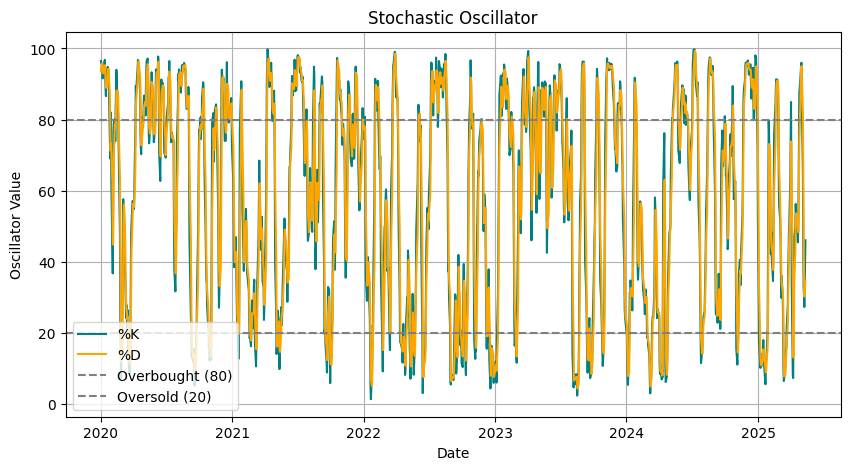

In [24]:
# Plot Stochastic Oscillator (%K and %D)
slowk, slowd = calculate_stochastic(history_adj)
slowk = slowk.loc['2020-01-01':]
slowd = slowd.loc['2020-01-01':]

plt.figure(figsize=(10, 5))
plt.plot(slowk.index, slowk, label='%K', color='teal')
plt.plot(slowd.index, slowd, label='%D', color='orange')
plt.axhline(80, color='gray', linestyle='--', label='Overbought (80)')
plt.axhline(20, color='gray', linestyle='--', label='Oversold (20)')
plt.title('Stochastic Oscillator')
plt.xlabel('Date')
plt.ylabel('Oscillator Value')
plt.legend()
plt.grid(True)
plt.show()


### 2.5 Finalizing the Technical Feature Set

This step compiles all previously defined technical indicators into a single feature-rich DataFrame. Each indicator is computed from adjusted historical price data and appended as a new column.

After computing all indicators, rows containing missing values are dropped to ensure data consistency for downstream modeling tasks.

In [25]:
def add_technical_indicators(df):
    """
    Add all agreed-upon technical indicators to the provided historical DataFrame (assumed to use adjusted prices).
    
    Parameters:
    - df: DataFrame, must contain 'close_adj', 'high_adj', 'low_adj', and 'volume_adj'
    
    Returns:
    - df: DataFrame with new columns added for each technical indicator
    """
    df['sma_10'] = calculate_sma(df, window=10)
    df['sma_50'] = calculate_sma(df, window=50)
    df['ema_12'] = calculate_ema(df, span=12)
    df['ema_26'] = calculate_ema(df, span=26)
    df['macd'], df['macd_signal'] = calculate_macd(df)
    df['rsi_14'] = calculate_rsi(df, window=14)
    df['bb_upper'], df['bb_middle'], df['bb_lower'] = calculate_bollinger_bands(df, window=20)
    df['atr_14'] = calculate_atr(df, window=14)
    df['obv'] = calculate_obv(df)
    df['roc_12'] = calculate_roc(df, window=12)
    df['stoch_k'], df['stoch_d'] = calculate_stochastic(df, k_period=14, d_period=3)

    df.ffill().dropna(inplace=True)
    
    return df

In [26]:
technical = add_technical_indicators(history_adj)
technical

,open_adj,high_adj,low_adj,close_adj,volume_adj,dividends,stock_splits,sma_10,sma_50,ema_12,...,macd_signal,rsi_14,bb_upper,bb_middle,bb_lower,atr_14,obv,roc_12,stoch_k,stoch_d
Date,,,,,,,,,,,,,,,,,,,,,
2005-09-30,1.574798,1.614521,1.561256,1.613318,531633200,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.316332e+08,NaN,NaN,NaN
2005-10-03,1.629870,1.641305,1.615425,1.638296,507553200,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.039186e+09,NaN,NaN,NaN
2005-10-04,1.653643,1.665681,1.614220,1.617531,539459200,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.997272e+08,NaN,NaN,NaN
2005-10-05,1.634985,1.635888,1.587438,1.588340,610769600,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.110424e+08,NaN,NaN,NaN
2005-10-06,1.600979,1.609706,1.530861,1.555839,757537200,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-8.685796e+08,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-06,198.210007,200.649994,197.020004,198.509995,51216500,0.0,0.0,207.217001,213.684601,204.458987,...,-2.454296,43.114373,219.516970,201.041001,182.565032,7.998245,4.474223e+10,0.776728,44.875431,64.961731
2025-05-07,199.169998,199.440002,193.250000,196.250000,68536700,0.0,0.0,206.382001,212.668801,203.196066,...,-2.420580,41.487535,215.515615,202.232501,188.949387,7.869085,4.467369e+10,1.599708,32.619530,47.512092
2025-05-08,197.720001,200.050003,194.679993,197.490005,50478900,0.0,0.0,205.294002,211.811401,202.318210,...,-2.450781,42.763665,215.529853,202.164501,188.799149,7.690579,4.472417e+10,-1.126464,30.734017,36.076326


In [27]:
technical.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4934 entries, 2005-09-30 to 2025-05-12
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open_adj      4934 non-null   float64
 1   high_adj      4934 non-null   float64
 2   low_adj       4934 non-null   float64
 3   close_adj     4934 non-null   float64
 4   volume_adj    4934 non-null   int64  
 5   dividends     4934 non-null   float64
 6   stock_splits  4934 non-null   float64
 7   sma_10        4925 non-null   float64
 8   sma_50        4885 non-null   float64
 9   ema_12        4923 non-null   float64
 10  ema_26        4909 non-null   float64
 11  macd          4901 non-null   float64
 12  macd_signal   4901 non-null   float64
 13  rsi_14        4920 non-null   float64
 14  bb_upper      4915 non-null   float64
 15  bb_middle     4915 non-null   float64
 16  bb_lower      4915 non-null   float64
 17  atr_14        4920 non-null   float64
 18  obv       

## 3. Fundamental Ratios

Fundamental ratios are financial metrics derived from company financial statements (income statement, balance sheet, and cash flow). They are crucial for assessing the underlying health, valuation, and financial performance of a company. These metrics complement technical indicators by providing a longer-term, business-focused perspective.

This section computes a variety of fundamental ratios, organized by analytical theme:

- **Profitability** (e.g., Return on Equity)

- **Valuation** (e.g., P/E, P/B)

- **Growth** (e.g., EPS Growth QoQ, YoY)

- **Capital Structure** (e.g., Debt-to-Equity)

- **Cash Flow** (e.g., EV/EBITDA Free Cash Flow Yield)

To ensure consistency and avoid forward-looking bias, each ratio is lagged by a set number of business days (**30** for quarterly statements, **45** for annual), simulating the reporting delay typically seen in real-world financial data releases.

In [28]:
def lag_series(series, lag_days=30):
    """Shift a Series forward by a number of business days."""
    series = series.copy()
    series.index = pd.to_datetime(series.index)
    series.index.name = "filingDate"

    # Drop duplicate index values before shifting
    series = series[~series.index.duplicated(keep='first')]
    
    return pd.DataFrame(series.shift(lag_days, freq="B"))

### 3.1 Profitability 

#### Return on Equity (ROE)

ROE measures how efficiently a company generates profit relative to its shareholders’ equity. It reflects management’s ability to generate returns on invested capital.

- **Formula:** ROE = Net Income / Total Shareholder Equity

- **Use:** Higher ROE indicates more efficient use of equity capital. It is useful for comparing profitability across companies in the same sector.


In [29]:
def calculate_roe(history_raw, income_statement_quarterly, balance_sheet_quarterly):
    """
    Calculate Return on Equity (ROE) using quarterly net income and shareholder equity.

    Parameters:
        history_raw (DataFrame): Unadjusted historical stock price.
        income_statement_quarterly (DataFrame): Quarterly income statements.
        balance_sheet_quarterly (DataFrame): Quarterly balance sheets.

    Returns:
        DataFrame: ROE values, lagged and aligned with historical dates.
    """
    # ROE = Net Income / Shareholder Equity
    roe = income_statement_quarterly['netIncome'] / balance_sheet_quarterly['totalShareholderEquity']
    
    # Align with price data index using forward fill
    roe = roe.reindex(history_raw.index, method='ffill')
    
    # Apply 30 business day lag to simulate financial report delay
    return lag_series(roe.rename("roe"))

### 3.2 Valuation 

#### Price-to-Earnings Ratio (P/E)

The P/E ratio compares a company's stock price to its earnings per share (EPS). It is one of the most widely used valuation metrics.

- **Formula:** P/E = Stock Price / Earnings per Share, EPS = Net Income / Shares Outstanding

- **Use:** Indicates how much investors are willing to pay for each dollar of earnings. A high P/E may imply growth expectations; a low P/E could indicate undervaluation.


In [30]:
def calculate_pe_ratio(history_raw, income_statement_quarterly, balance_sheet_quarterly):
    """
    Calculate the Price-to-Earnings (P/E) ratio using quarterly data.

    Parameters:
        history_raw (DataFrame): Unadjusted historical stock price.
        income_statement_quarterly (DataFrame): Quarterly income statements.
        balance_sheet_quarterly (DataFrame): Quarterly balance sheets.

    Returns:
        DataFrame: P/E ratio values, lagged.
    """
    # EPS = Net Income / Shares Outstanding
    eps = income_statement_quarterly['netIncome'] / balance_sheet_quarterly['commonStockSharesOutstanding']
    eps = eps.reindex(history_raw.index, method='ffill')

    # P/E = Price / EPS
    pe = (history_raw['close_raw'] / eps).ffill().dropna()

    return lag_series(pe.rename("pe_ratio"))

#### Price-to-Book Ratio (P/B)

P/B compares the market value of a company's stock to its book value (equity per share).

- **Formula:** P/B = Stock Price / Book Value per Share

- **Use:** Useful for evaluating asset-heavy businesses. A P/B ratio below 1 can suggest a potentially undervalued stock.

In [31]:
def calculate_pb_ratio(history_raw, balance_sheet_annual):
    """
    Calculate the Price-to-Book (P/B) ratio using annual balance sheet data.

    Parameters:
        history_raw (DataFrame): Unadjusted historical stock price.
        balance_sheet_annual (DataFrame): Annual balance sheets.

    Returns:
        DataFrame: P/B ratio values, lagged.
    """
    # Book Value Per Share = Equity / Shares Outstanding
    bvps = balance_sheet_annual['totalShareholderEquity'] / balance_sheet_annual['commonStockSharesOutstanding']
    bvps = bvps.reindex(history_raw.index, method='ffill')

    # P/B = Price / Book Value Per Share
    pb = (history_raw['close_raw'] / bvps).ffill().dropna()

    return lag_series(pb.rename("pb_ratio"), lag_days=45)

### 3.3 Growth 

#### EPS Growth (QoQ and YoY)

Earnings Per Share (EPS) growth tracks the percentage change in earnings relative to the previous quarter (QoQ) or year (YoY).

- **QoQ EPS Growth:**  
EPS_qoq = (EPS_t - EPS_t-1) / EPS_t-1


- **YoY EPS Growth:**  
EPS_yoy = (EPS_t - EPS_t-4) / EPS_t-4


**Use:**  
These metrics help assess earnings momentum and are critical for growth investing strategies. A company with consistent positive EPS growth is typically viewed favorably by investors.


In [32]:
def calculate_eps_growth_qoq(history_raw, income_statement_quarterly, balance_sheet_quarterly):
    """
    Calculate Quarter-over-Quarter EPS growth.

    Parameters:
        history_raw (DataFrame): Unadjusted historical stock price.
        income_statement_quarterly (DataFrame): Quarterly income statements.
        balance_sheet_quarterly (DataFrame): Quarterly balance sheets.

    Returns:
        DataFrame: QoQ EPS growth values, lagged.
    """
    # EPS = Net Income / Shares Outstanding
    eps = (income_statement_quarterly['netIncome'] / balance_sheet_quarterly['commonStockSharesOutstanding']).dropna()

    # Compute percentage change from previous quarter
    eps_growth = eps.pct_change(1)
    eps_growth = eps_growth.reindex(history_raw.index, method='ffill')

    return lag_series(eps_growth.rename("eps_growth_qoq"))

In [33]:
def calculate_eps_growth_yoy(history_raw, income_statement_annual, balance_sheet_annual):
    """
    Calculate Year-over-Year EPS growth using annual data.

    Parameters:
        history_raw (DataFrame): Unadjusted historical stock price.
        income_statement_annual (DataFrame): Annual income statements.
        balance_sheet_annual (DataFrame): Annual balance sheets.

    Returns:
        DataFrame: YoY EPS growth values, lagged.
    """
    # EPS = Net Income / Shares Outstanding
    eps = (income_statement_annual['netIncome'] / balance_sheet_annual['commonStockSharesOutstanding']).dropna()

    # Compute percentage change from previous year
    eps_growth = eps.pct_change(1)
    eps_growth = eps_growth.reindex(history_raw.index, method='ffill')

    return lag_series(eps_growth.rename("eps_growth_yoy"), lag_days=45)

### 3.4 Capital Structure

#### Debt-to-Equity Ratio (D/E)

This ratio measures a company’s financial leverage by comparing total liabilities to shareholders’ equity.

- **Formula:** D/E = Total Liabilities / Shareholder Equity


- **Use:** A higher ratio indicates greater leverage (and risk). It helps assess how reliant a firm is on debt to finance its operations.


In [34]:
def calculate_de_ratio(history_raw, balance_sheet_quarterly):
    """
    Calculate Debt-to-Equity (D/E) ratio.

    Parameters:
        history_raw (DataFrame): Unadjusted historical stock price.
        balance_sheet_quarterly (DataFrame): Quarterly balance sheets.

    Returns:
        DataFrame: D/E ratio values, lagged.
    """
    # D/E = Total Liabilities / Shareholder Equity
    de = balance_sheet_quarterly['totalLiabilities'] / balance_sheet_quarterly['totalShareholderEquity']
    de = de.reindex(history_raw.index, method='ffill')

    return lag_series(de.rename("de_ratio"))

### 3.5 Cash Flow

#### Enterprise Value to EBITDA (EV/EBITDA)

EV/EBITDA compares the entire value of a company (EV) to its earnings before interest, tax, depreciation, and amortization (EBITDA).

- **Formula:**  
    EV = Market Cap + Total Liabilities - Cash  
    EV/EBITDA = EV / EBITDA


- **Use:**  
Common for comparing company valuations independent of capital structure or tax environments.

In [35]:
def calculate_ev_ebitda(history_raw, income_statement_quarterly, balance_sheet_quarterly):
    """
    Calculate Enterprise Value to EBITDA (EV/EBITDA) ratio.

    Parameters:
        history_raw (DataFrame): Unadjusted historical stock price.
        income_statement_quarterly (DataFrame): Quarterly income statements.
        balance_sheet_quarterly (DataFrame): Quarterly balance sheets.

    Returns:
        DataFrame: EV/EBITDA ratio values, lagged.
    """
    # Extract required components
    debt = balance_sheet_quarterly['totalLiabilities'].reindex(history_raw.index, method='ffill')
    cash = balance_sheet_quarterly['cashAndCashEquivalentsAtCarryingValue'].reindex(history_raw.index, method='ffill')
    shares = balance_sheet_quarterly['commonStockSharesOutstanding'].reindex(history_raw.index, method='ffill')

    # Market Cap = Price * Shares Outstanding
    market_cap = history_raw['close_raw'] * shares

    # Enterprise Value = Market Cap + Debt - Cash
    ev = market_cap + debt - cash

    # EV/EBITDA
    ev_ebitda = (ev / income_statement_quarterly['ebitda'].reindex(history_raw.index, method='ffill')).ffill().dropna()

    return lag_series(ev_ebitda.rename("ev_ebitda"))

#### Free Cash Flow Yield (FCF Yield)

This ratio measures a firm’s ability to generate excess cash relative to its market value.

- **Formula:** FCF Yield = (Operating Cash Flow - Capital Expenditures) / Market Capitalization

- **Use:** Highlights a company’s financial flexibility and potential to return value to shareholders via dividends or reinvestments.


In [36]:
def calculate_fcf_yield(history_raw, cash_flow_annual, balance_sheet_annual):
    """
    Calculate Free Cash Flow Yield (FCF Yield).

    Parameters:
        history_raw (DataFrame): Unadjusted historical stock price.
        cash_flow_annual (DataFrame): Annual cash flow statements.
        balance_sheet_annual (DataFrame): Annual balance sheets.

    Returns:
        DataFrame: FCF Yield values, lagged.
    """
    # Free Cash Flow = Operating Cash Flow - Capital Expenditures
    fcf = cash_flow_annual['operatingCashflow'] - cash_flow_annual['capitalExpenditures']

    # Market Cap = Price * Shares Outstanding
    market_cap = history_raw['close_raw'] * balance_sheet_annual['commonStockSharesOutstanding']

    # FCF Yield = FCF / Market Cap
    fcf_yield = fcf / market_cap
    fcf_yield = fcf_yield.reindex(history_raw.index, method='ffill')

    return lag_series(fcf_yield.rename("fcf_yield"), lag_days=45)

### 3.6 Finalize Fundamental Feature Set

All computed fundamental ratios are added as new columns to the raw historical price DataFrame. Each feature is lagged appropriately to simulate realistic data availability (i.e., earnings reports coming out after quarter-end).

After aligning and forward-filling missing values, any remaining rows with NaN are dropped to ensure consistency across the dataset before merging with technical indicators.

In [37]:
def add_fundamental_ratios(df, income_statement_quarterly, income_statement_annual, balance_sheet_quarterly, balance_sheet_annual, cash_flow_annual):
    """
    Add all fundamental ratios to a stock's historical price DataFrame.

    Parameters:
        df (DataFrame): Unadjusted historical price data.
        income_statement_quarterly (DataFrame)
        balance_sheet_quarterly (DataFrame)
        cash_flow_annual (DataFrame)
        balance_sheet_annual (DataFrame)

    Returns:
        DataFrame: Input DataFrame with all fundamental ratios added as new columns.
    """
    df['roe'] = calculate_roe(df, income_statement_quarterly, balance_sheet_quarterly)
    df['pe_ratio'] = calculate_pe_ratio(df, income_statement_quarterly, balance_sheet_quarterly)
    df['pb_ratio'] = calculate_pb_ratio(df, balance_sheet_annual)
    df['eps_growth_qoq'] = calculate_eps_growth_qoq(df, income_statement_quarterly, balance_sheet_quarterly)
    df['eps_growth_yoy'] = calculate_eps_growth_yoy(df, income_statement_annual, balance_sheet_annual)
    df['ev_ebitda'] = calculate_ev_ebitda(df, income_statement_quarterly, balance_sheet_quarterly)
    df['de_ratio'] = calculate_de_ratio(df, balance_sheet_quarterly)
    df['fcf_yield'] = calculate_fcf_yield(df, cash_flow_annual, balance_sheet_annual)

    # Drop rows with missing values after feature addition
    return df.ffill().dropna()


In [38]:
fundamental = add_fundamental_ratios(history_raw, income_statement_quarterly, income_statement_annual, balance_sheet_quarterly, balance_sheet_annual, cash_flow_annual)
fundamental

,open_raw,high_raw,low_raw,close_raw,volume_raw,roe,pe_ratio,pb_ratio,eps_growth_qoq,eps_growth_yoy,ev_ebitda,de_ratio,fcf_yield
Date,,,,,,,,,,,,,
2006-12-04,91.880,92.0500,90.5000,91.12,25340600,0.054287,3687.989380,184.231240,0.148305,0.462499,2785.124295,0.723257,0.001769
2006-12-05,91.655,92.3300,90.8700,91.27,23672800,0.054287,3669.427194,182.287042,0.148305,0.462499,2771.112172,0.723257,0.001769
2006-12-06,90.645,91.3900,89.6700,89.83,22792300,0.054287,3697.949577,185.510965,0.148305,0.462499,2792.642995,0.723257,0.001769
2006-12-07,90.025,90.5000,86.9000,87.04,35886700,0.054287,3721.039125,184.157409,0.148305,0.462499,2810.072710,0.723257,0.001769
2006-12-08,87.230,89.3900,87.0000,88.26,28009900,0.054287,3640.452075,182.656193,0.148305,0.462499,2749.239589,0.723257,0.001769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-06,198.210,200.6500,197.0200,198.51,51216482,0.544204,93.311479,63.831990,1.507248,-0.008232,79.217504,4.154214,0.030308
2025-05-07,199.170,199.4400,193.2500,196.25,68616943,0.544204,92.385663,63.780585,1.507248,-0.008232,78.484909,4.154214,0.030308
2025-05-08,197.720,200.0500,194.6796,197.49,50478872,0.544204,93.353183,63.669658,1.507248,-0.008232,79.250504,4.154214,0.030308


In [39]:
fundamental.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4638 entries, 2006-12-04 to 2025-05-12
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open_raw        4638 non-null   float64
 1   high_raw        4638 non-null   float64
 2   low_raw         4638 non-null   float64
 3   close_raw       4638 non-null   float64
 4   volume_raw      4638 non-null   int64  
 5   roe             4638 non-null   float64
 6   pe_ratio        4638 non-null   float64
 7   pb_ratio        4638 non-null   float64
 8   eps_growth_qoq  4638 non-null   float64
 9   eps_growth_yoy  4638 non-null   float64
 10  ev_ebitda       4638 non-null   float64
 11  de_ratio        4638 non-null   float64
 12  fcf_yield       4638 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 507.3 KB


## 4. Feature Set Generation

This function generates a full feature set for a given stock by combining technical indicators and fundamental ratios.

In [48]:
def generate_full_feature_set(stock, base_path="dataset\\Stocks\\"):
    """
    Generate a full feature set for the given stock.
    
    Parameters:
    - stock: str, stock ticker symbol
    
    Returns:
    - DataFrame with all features
    """
    base_path = os.path.join(base_path, stock)

    try:
        (
            history_raw, history_adj,
            balance_sheet_annual, balance_sheet_quarterly,
            income_statement_annual, income_statement_quarterly,
            cash_flow_annual, cash_flow_quarterly
        ) = load_dataframes(base_path, stock)

        start_date = determine_start_date(history_raw, history_adj, balance_sheet_annual, balance_sheet_quarterly, income_statement_annual, income_statement_quarterly, cash_flow_annual, cash_flow_quarterly)

        (
            history_raw,
            history_adj,
            balance_sheet_annual,
            balance_sheet_quarterly,
            income_statement_annual,
            income_statement_quarterly,
            cash_flow_annual,
            cash_flow_quarterly
        ) = prepare_financial_data(
            start_date,
            history_raw,
            history_adj,
            balance_sheet_annual,
            balance_sheet_quarterly,
            income_statement_annual,
            income_statement_quarterly,
            cash_flow_annual,
            cash_flow_quarterly
        )

        technical = add_technical_indicators(history_adj)
        fundamental = add_fundamental_ratios(history_raw, income_statement_quarterly, income_statement_annual, balance_sheet_quarterly, balance_sheet_annual, cash_flow_annual)

        full_feature_set = pd.concat([technical, fundamental], axis=1).dropna()
        
        print(f"Full feature set for {stock} generated with {full_feature_set.shape[0]} rows and {full_feature_set.shape[1]} columns.")

        return full_feature_set

    except Exception as e:
        print(f"Error in generate_full_feature_set for {stock}: {e}")
        return pd.DataFrame()

In [42]:
feature_set = generate_full_feature_set(stock)
feature_set

,open_adj,high_adj,low_adj,close_adj,volume_adj,dividends,stock_splits,sma_10,sma_50,ema_12,...,close_raw,volume_raw,roe,pe_ratio,pb_ratio,eps_growth_qoq,eps_growth_yoy,ev_ebitda,de_ratio,fcf_yield
Date,,,,,,,,,,,,,,,,,,,,,
2006-12-04,2.765000,2.770116,2.723471,2.742129,709536800,0.0,0.0,2.721244,2.440717,2.692444,...,91.12,25340600.0,0.054287,3687.989380,184.231240,0.148305,0.462499,2785.124295,0.723257,0.001769
2006-12-05,2.758078,2.778542,2.734605,2.746643,662838400,0.0,0.0,2.735689,2.450058,2.700782,...,91.27,23672800.0,0.054287,3669.427194,182.287042,0.148305,0.462499,2771.112172,0.723257,0.001769
2006-12-06,2.727684,2.750254,2.698493,2.703308,638184400,0.0,0.0,2.739390,2.457413,2.701171,...,89.83,22792300.0,0.054287,3697.949577,185.510965,0.148305,0.462499,2792.642995,0.723257,0.001769
2006-12-07,2.709327,2.723472,2.615134,2.619347,1004827600,0.0,0.0,2.729550,2.463811,2.688583,...,87.04,35886700.0,0.054287,3721.039125,184.157409,0.148305,0.462499,2810.072710,0.723257,0.001769
2006-12-08,2.625064,2.690067,2.618143,2.656061,784277200,0.0,0.0,2.719408,2.470582,2.683579,...,88.26,28009900.0,0.054287,3640.452075,182.656193,0.148305,0.462499,2749.239589,0.723257,0.001769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-06,198.210007,200.649994,197.020004,198.509995,51216500,0.0,0.0,207.217001,213.684601,204.458987,...,198.51,51216482.0,0.544204,93.311479,63.831990,1.507248,-0.008232,79.217504,4.154214,0.030308
2025-05-07,199.169998,199.440002,193.250000,196.250000,68536700,0.0,0.0,206.382001,212.668801,203.196066,...,196.25,68616943.0,0.544204,92.385663,63.780585,1.507248,-0.008232,78.484909,4.154214,0.030308
2025-05-08,197.720001,200.050003,194.679993,197.490005,50478900,0.0,0.0,205.294002,211.811401,202.318210,...,197.49,50478872.0,0.544204,93.353183,63.669658,1.507248,-0.008232,79.250504,4.154214,0.030308


In [43]:
feature_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4638 entries, 2006-12-04 to 2025-05-12
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open_adj        4638 non-null   float64
 1   high_adj        4638 non-null   float64
 2   low_adj         4638 non-null   float64
 3   close_adj       4638 non-null   float64
 4   volume_adj      4638 non-null   int64  
 5   dividends       4638 non-null   float64
 6   stock_splits    4638 non-null   float64
 7   sma_10          4638 non-null   float64
 8   sma_50          4638 non-null   float64
 9   ema_12          4638 non-null   float64
 10  ema_26          4638 non-null   float64
 11  macd            4638 non-null   float64
 12  macd_signal     4638 non-null   float64
 13  rsi_14          4638 non-null   float64
 14  bb_upper        4638 non-null   float64
 15  bb_middle       4638 non-null   float64
 16  bb_lower        4638 non-null   float64
 17  atr_14         

This function saves the full feature set for a given stock in a given directory.

In [53]:
def save_feature_set(stock, df, base_path = f"dataset\\Stocks\\"):
    """
    Save the DataFrame to a CSV file with a name based on the stock symbol.

    Parameters:
        stock (str): The stock symbol used in the filename.
        df (pd.DataFrame): The DataFrame to save.
        base_path (str): The directory path where the file will be saved.

    Returns:
        None
    """
    csv_path = os.path.join(base_path, stock)
    df.to_csv(f"{csv_path}\\{stock}_full_feature_set.csv", index=True)
    print(f"Feature set saved to {csv_path}\\{stock}_full_feature_set.csv")

In [45]:
save_feature_set(stock, feature_set, base_path)

## 5. Batch Processing

Processes all stock folders within the main dataset directory by applying the generate_full_feature_set function.

In [54]:
# Path to your main folder
base_path = f"dataset\\Stocks\\"

# List all directories (stock symbols) within the main folder
stocks = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# Iterate over each stock folder
for stock in stocks:
    try:
        feature_set = generate_full_feature_set(stock)
        save_feature_set(stock, feature_set)

        print(f"'{stock}' Done.")
    except Exception as e:
        print(f"'{stock}' skipped. Error: {e}")
        continue

Full feature set for AAPL generated with 4638 rows and 35 columns.
Feature set saved to dataset\Stocks\AAPL\AAPL_full_feature_set.csv
'AAPL' Done.
Full feature set for JNJ generated with 4331 rows and 35 columns.
Feature set saved to dataset\Stocks\JNJ\JNJ_full_feature_set.csv
'JNJ' Done.
Full feature set for NVDA generated with 4560 rows and 35 columns.
Feature set saved to dataset\Stocks\NVDA\NVDA_full_feature_set.csv
'NVDA' Done.
Full feature set for PG generated with 4706 rows and 35 columns.
Feature set saved to dataset\Stocks\PG\PG_full_feature_set.csv
'PG' Done.
Full feature set for XOM generated with 4331 rows and 35 columns.
Feature set saved to dataset\Stocks\XOM\XOM_full_feature_set.csv
'XOM' Done.
